# import OCR

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import time, io
from tqdm import tqdm
import tensorflow as tf
import sklearn
from PIL import Image
import numpy as np
import pickle
from cleverhans import utils_tf
from util import cvt2Image, sparse_tuple_from

In [3]:
from calamari_ocr.ocr.backends.tensorflow_backend.tensorflow_model import TensorflowModel
from calamari_ocr.ocr import Predictor
checkpoint = '/home/chenlu/calamari/models/antiqua_modern/4.ckpt.json'
predictor = Predictor(checkpoint=checkpoint, batch_size=1, processes=10)

Checkpoint version 1 is up-to-date.
charset: ['', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}']
Using CUDNN LSTM backend on GPU
Successfully load the model's weights
INFO:tensorflow:Restoring parameters from /home/chenlu/calamari/models/antiqua_modern/4.ckpt


In [4]:
network = predictor.network
sess, graph = network.session, network.graph
codec = network.codec
charset = codec.charset
encode, decode = codec.encode, codec.decode
code2char, char2code = codec.code2char, codec.char2code

In [5]:
def invert(data): # 反色
    if data.max() < 1.5:
        return 1 - data
    else:
        return 255 - data

def transpose(data): # 旋转90度
    if len(data.shape) != 2:
        return np.swapaxes(data, 1, 2)
    else:
        return data.T

def cvt2raw(data):
    return transpose(invert(data))

def show(img):
    return cvt2Image(cvt2raw(img))

In [88]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
font_name, case, pert_type, eps, eps_iter, nb_iter = 'Arial', 'easy', '2', 0.2, 5.0,1000 

with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    _, input_img, len_x, gt_txt, target_txt = pickle.load(f)
input_img = np.asarray(input_img)

title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
with open(f'wm_result/{title}.pkl', 'rb') as f:
    (_, wm0_mask, _, wm0_img, record_text, _, adv_img, record_adv_text, record_iter, _, _) = pickle.load(f)

In [89]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/intersect_word.pkl', 'rb') as f:
    intersect_word = pickle.load(f)
intersect_word = set(intersect_word)

def filter_word(input_img, len_x, gt_txt, target_txt):
    new_input_img, new_len_x, new_gt_txt, new_target_txt = [], [], [], []
    for i, gt in enumerate(gt_txt):
        if gt in intersect_word:
            new_input_img.append(input_img[i])
            new_len_x.append(len_x[i])
            new_gt_txt.append(gt_txt[i])
            new_target_txt.append(target_txt[i])
    return np.asarray(new_input_img), new_len_x, new_gt_txt, new_target_txt
input_img, len_x, gt_txt, target_txt = filter_word(input_img, len_x, gt_txt, target_txt)

In [91]:
nb_sample = 1000
len_x, target_txt = len_x[:nb_sample], target_txt[:nb_sample]
input_img = input_img[:nb_sample]

wm0_img = wm0_img[:nb_sample]
wm_mask_img = wm0_mask[:nb_sample].astype('float32')

# hyper-parameter

In [80]:
shape = tuple([batch_size] + list(input_img.shape[1:]))  # (batch_size, height, width, channel)

In [81]:
LEARNING_RATE = learning_rate = 0.01 # float
ABORT_EARLY = abort_early = True # bool
batch_size = batch_size = 100 # int
clip_min, clip_max = 0.0, 1.0
np_dtype = np.dtype('float32')
tf_dtype = tf.as_dtype('float32')

MAX_ITERATIONS = 1000
BINARY_SEARCH_STEPS = 1
initial_const = 100  # float
LEARNING_RATE = 0.01

# basic optimization method

## build graph

In [140]:
# build graph
with graph.as_default():
    # the variable we're going to optimize over
    modifier = tf.Variable(np.zeros(shape, dtype=np_dtype))  # (batch_size, height, width, channel)
    # these are variables to be more efficient in sending data to tf
    timg = tf.Variable(np.zeros(shape), dtype=tf_dtype, name='timg')
    input_seq_len = tf.Variable(np.zeros(batch_size), dtype=tf.int32, name='seq_len')
    const = tf.Variable(np.zeros(batch_size), dtype=tf_dtype, name='const')
    # and here's what we use to assign them
    assign_timg, assign_input_seq_len, targets, dropout_rate, _, _ = network.create_placeholders()
    assign_const = tf.placeholder(tf_dtype, [batch_size], name='assign_const')
    
    # the resulting instance, tanh'd to keep bounded from clip_min to clip_max
    newimg = (tf.tanh(modifier + timg) + 1) / 2
    newimg = newimg * (clip_max - clip_min) + clip_min 
    # prediction BEFORE-SOFTMAX of the model
    output_seq_len, time_major_logits, time_major_softmax, logits, softmax, decoded, sparse_decoded, scale_factor, \
            log_prob = network.create_network(newimg, input_seq_len, dropout_rate, reuse_variables=tf.AUTO_REUSE)
    # distance to the input data
        
    # ctc loss
    loss1 = tf.nn.ctc_loss(labels=targets,
                           inputs=time_major_logits,
                           sequence_length=output_seq_len,
                           time_major=True,
                           ctc_merge_repeated=True,
                           ignore_longer_outputs_than_inputs=True)
    loss1 = tf.reduce_sum(const * loss1) # mu * ctc_loss
    
    # L2-norm distance
    other = (tf.tanh(timg) + 1) / 2 * (clip_max - clip_min) + clip_min  
    l2dist = tf.reduce_sum(tf.square(newimg - other), axis=list(range(1, len(shape))))
    loss2 = tf.reduce_sum(l2dist) 
    
    # nps: non-printability score
    closest_val = tf.round(newimg * 255)  # 乘 255 取整
    loss3 = 1e-2 * tf.reduce_sum(tf.abs(255 * newimg - closest_val))

    # tv: total variation
    n_x, n_y = input_img.shape[1], input_img.shape[2]
    tmp1 = modifier[:, :n_x - 1, :n_y - 1]
    tmp2 = modifier[:, 1:n_x, :n_y - 1]
    tmp3 = modifier[:, :n_x - 1, 1:n_y]
    tv = tf.sqrt(tf.square(tmp1 - tmp2) + tf.square(tmp1 - tmp3) + 1e-5)
    loss4 = tf.reduce_sum(1e-3 * tv)
    
    loss = loss1 + loss2 + loss4
    
    # Setup the adam optimizer and keep track of variables we're creating
    start_vars = set(x.name for x in tf.global_variables())
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
    train = optimizer.minimize(loss, var_list=[modifier])
    end_vars = tf.global_variables()
    new_vars = [x for x in end_vars if x.name not in start_vars] # 优化在 optimizer 和 train 里的变量
    
    # these are the variables to initialize when we run
    setup = []
    setup.append(timg.assign(assign_timg))
    setup.append(input_seq_len.assign(assign_input_seq_len))
    setup.append(const.assign(assign_const))

    init = tf.variables_initializer(var_list=[modifier] + new_vars)

Using CUDNN LSTM backend on GPU


## build graph + eps constraint

In [ ]:
# build graph
with graph.as_default():
    # the variable we're going to optimize over
    modifier = tf.Variable(np.zeros(shape, dtype=np_dtype))  # (batch_size, height, width, channel)
    # these are variables to be more efficient in sending data to tf
    timg = tf.Variable(np.zeros(shape), dtype=tf_dtype, name='timg')
    input_seq_len = tf.Variable(np.zeros(batch_size), dtype=tf.int32, name='seq_len')
    const = tf.Variable(np.zeros(batch_size), dtype=tf_dtype, name='const')
    # and here's what we use to assign them
    assign_timg, assign_input_seq_len, targets, dropout_rate, _, _ = network.create_placeholders()
    assign_const = tf.placeholder(tf_dtype, [batch_size], name='assign_const')
    
    # the resulting instance, tanh'd to keep bounded from clip_min to clip_max
    newimg = (tf.tanh(modifier + timg) + 1) / 2
    newimg = newimg * (clip_max - clip_min) + clip_min 
#     newimg = tf.clip_by_value(0.2 * tf.tanh(modifier) + timg, clip_min, clip_max)
#     newimg = (tf.tanh(0.5 * tf.tanh(modifier) + timg) + 1) / 2

    # prediction BEFORE-SOFTMAX of the model
    output_seq_len, time_major_logits, time_major_softmax, logits, softmax, decoded, sparse_decoded, scale_factor, \
            log_prob = network.create_network(newimg, input_seq_len, dropout_rate, reuse_variables=tf.AUTO_REUSE)
    # distance to the input data
    other = (tf.tanh(timg) + 1) / 2 * (clip_max - clip_min) + clip_min  
    l2dist = tf.reduce_sum(tf.square(newimg - other), axis=list(range(1, len(shape))))  # (batch_size, )
       
    # sum up the losses
    loss1 = tf.nn.ctc_loss(labels=targets,
                           inputs=time_major_logits,
                           sequence_length=output_seq_len,
                           time_major=True,
                           ctc_merge_repeated=True,
                           ignore_longer_outputs_than_inputs=True)
    loss1 = tf.reduce_sum(const * loss1) # mu * ctc_loss
    loss2 = tf.reduce_sum(l2dist) # L2-norm distance
    loss = loss1 + loss2
    
    # Setup the adam optimizer and keep track of variables we're creating
    start_vars = set(x.name for x in tf.global_variables())
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
    train = optimizer.minimize(loss, var_list=[modifier])
    end_vars = tf.global_variables()
    new_vars = [x for x in end_vars if x.name not in start_vars] # 优化在 optimizer 和 train 里的变量
    
    # these are the variables to initialize when we run
    setup = []
    setup.append(timg.assign(assign_timg))
    setup.append(input_seq_len.assign(assign_input_seq_len))
    setup.append(const.assign(assign_const))

    init = tf.variables_initializer(var_list=[modifier] + new_vars)

## run attack

In [141]:
# preprocess img
# imgs = input_img[:len(input_img) // batch_size * batch_size]
imgs = input_img[:batch_size]
imgs = (imgs - clip_min) / (clip_max - clip_min) # re-scale instances to be within range [0, 1]
imgs = np.clip(imgs, clip_min, clip_max)
imgs = (imgs * 2) - 1 # now convert to [-1, 1]
imgs = np.arctanh(imgs * .999999) # convert to tanh-space

In [142]:
with graph.as_default():
    adv_img_list = []
    adv_l2_list = []
    adv_txt_list = []
    adv_iter_list = []
    for i in range(0, len(imgs), batch_size):  # run attack in batch data
        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)  # (batch_size, )
        CONST = np.ones(batch_size) * initial_const  # (batch_size, )
        upper_bound = np.ones(batch_size) * 1e10  # (batch_size, )

        # placeholders for the best l2, score, and instance attack found so far
        o_bestl2 = [1e10] * batch_size  # (batch_size, )
        o_bestscore = [-1] * batch_size  # (batch_size, )
        o_bestattack = np.zeros(shape)
        o_bestiter = [-1] * batch_size

        for outer_step in range(BINARY_SEARCH_STEPS):  # 二分调整 const
            # completely reset adam's internal state.
            sess.run(init)
            batch = imgs[i:i + batch_size]
            batch_len_x = len_x[i:i + batch_size]
            batch_target_txt = target_txt[i:i + batch_size]
            batch_tmp_y = [
                np.asarray([c - 1 for c in encode(t)])
                for t in batch_target_txt
            ]
            batch_y = sparse_tuple_from(batch_tmp_y)

            bestl2 = [1e10] * batch_size  # (batch_size, )
            bestscore = [-1] * batch_size  # (batch_size, )
            bestiter = [-1] * batch_size
            print(
                f"  Binary search step {outer_step} of {BINARY_SEARCH_STEPS}")

            # set the variables so that we don't have to send them over again
            sess.run(
                setup, {
                    assign_timg: batch,
                    assign_input_seq_len: batch_len_x,
                    assign_const: CONST,
                })

            for iteration in range(MAX_ITERATIONS):  # 开始迭代攻击
                # perform the attack
                _, l, scores, l2s, batch_adv_txt, nimg, l4 = sess.run(
                    [train, loss, loss1, l2dist, decoded, newimg, loss4],
                    feed_dict={
                        targets: batch_y,
                        dropout_rate: 0
                    })
                batch_adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_adv_txt)
                batch_adv_txt = [''.join(decode(index)) for index in batch_adv_index]
                # attack done
                if iteration % ((MAX_ITERATIONS // 10) or 1) == 0:
                    print(f"Iteration {iteration} of {MAX_ITERATIONS} " +
                          f"loss={l:.1f} ctc_loss={np.mean(scores):.1f} " + 
                          f"l2s={np.mean(l2s):.3f} tv={np.mean(l4):.3f}")

                # adjust the best result found so far
                for e, (l2, ii) in enumerate(zip(l2s, nimg)):
                    target_t, adv_t = batch_target_txt[e], batch_adv_txt[e]
                    if l2 < bestl2[e] and target_t == adv_t:
                        bestl2[e] = l2
                        bestscore[e] = adv_t
                        if bestiter[e] == -1: # record success iter
                            bestiter[e] = iteration
                    if l2 < o_bestl2[e] and target_t == adv_t:
                        o_bestl2[e] = l2
                        o_bestscore[e] = adv_t  # batch_adv_txt
                        o_bestattack[e] = ii
                        if o_bestiter[e] == -1: # record success iter
                            o_bestiter[e] = iteration

                # check if we should abort search if we're getting nowhere.
                if ABORT_EARLY:
                    n_success = 0
                    for target_t, adv_t in zip(batch_target_txt, bestscore):
                        if target_t == adv_t:
                            n_success += 1
                    if iteration % ((MAX_ITERATIONS // 10) or 1) == 0:
                        print(f'acc: {n_success / len(batch_target_txt)}')
                    if n_success == len(batch_target_txt):
                        print(f"iteration[{iteration}] break, all attacks succeed!")
                        break

            # adjust the constant as needed
            for e in range(batch_size):  # 二分调整 const
                if bestscore[e] == batch_target_txt[e]:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e], CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e]) / 2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    # or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        CONST[e] *= 10

            print(
                f"Successfully generated adversarial examples on {sum(upper_bound < 1e9)} of {batch_size} instances."
            )
            o_bestl2 = np.array(o_bestl2)
            mean = np.mean(np.sqrt(o_bestl2[o_bestl2 < 1e9]))
            print(f"Mean successful distortion: {mean:.4g}")

        # return the best solution found
        o_bestl2 = np.array(o_bestl2)
        adv_l2_list.append(o_bestl2)
        adv_txt_list += o_bestscore
        adv_img_list.append(o_bestattack)  # 把 batch adv img 加到 list 中
        adv_iter_list += o_bestiter
        print('-' * 30, i, '-' * 30)

adv_img = np.asarray(adv_img_list).reshape(imgs.shape)
adv_l2 = np.asarray(adv_l2_list).reshape(-1)

  Binary search step 0 of 1
Iteration 0 of 1000 loss=316270.0 ctc_loss=316267.1 l2s=0.000 tv=2.854
acc: 0.0
Iteration 100 of 1000 loss=39492.6 ctc_loss=37707.1 l2s=16.846 tv=100.849
acc: 0.47
Iteration 200 of 1000 loss=5321.8 ctc_loss=3187.0 l2s=20.284 tv=106.456
acc: 0.95
Iteration 300 of 1000 loss=3076.4 ctc_loss=1182.5 l2s=17.968 tv=97.049
acc: 0.98
Iteration 400 of 1000 loss=2355.1 ctc_loss=659.4 l2s=16.061 tv=89.617
acc: 0.98
Iteration 500 of 1000 loss=1937.2 ctc_loss=399.8 l2s=14.537 tv=83.658
acc: 0.99
Iteration 600 of 1000 loss=1755.4 ctc_loss=345.2 l2s=13.313 tv=78.895
acc: 0.99
Iteration 700 of 1000 loss=1615.7 ctc_loss=303.1 l2s=12.374 tv=75.117
acc: 0.99
Iteration 800 of 1000 loss=1497.5 ctc_loss=264.5 l2s=11.609 tv=72.026
acc: 0.99
Iteration 900 of 1000 loss=1411.4 ctc_loss=245.9 l2s=10.961 tv=69.375
acc: 0.99
Successfully generated adversarial examples on 99 of 100 instances.
Mean successful distortion: 3.08
------------------------------ 0 ------------------------------


foy


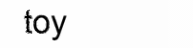

In [145]:
print(target_txt[0])
show(adv_img[0])

In [ ]:
adv_img[0]

In [ ]:
initial_const = 50  # float

In [100]:
from skimage.measure import compare_ssim, compare_mse, compare_psnr

In [103]:
compare_mse(adv_img*255, input_img* 255)

121.9368019663174

In [106]:
np.mean(np.array(adv_iter_list))

111.466

In [104]:
np.mean(((adv_img - input_img)*255)**2)

121.93680196631742

adv_text: fandom target_txt fandom


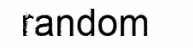

In [48]:
idx = 8
print("adv_text:", adv_txt_list[idx],"target_txt", target_txt[idx])
show(adv_img[idx]) # basic optimized img

# wm optimization method

## build graph

In [33]:
# build graph
with graph.as_default():
    # these are variables to be more efficient in sending data to tf
    timg = tf.Variable(np.zeros(shape), dtype=tf_dtype, name='timg')
    input_seq_len = tf.Variable(np.zeros(batch_size), dtype=tf.int32, name='seq_len')
    wm_mask = tf.Variable(np.zeros(shape), dtype=tf_dtype, name='wm_mask')
    const = tf.Variable(np.zeros(batch_size), dtype=tf_dtype, name='const')
    # and here's what we use to assign them
    assign_timg, assign_input_seq_len, targets, dropout_rate, _, _ = network.create_placeholders()
    assign_wm_mask = tf.placeholder(tf_dtype, shape, name='assign_const')
    assign_const = tf.placeholder(tf_dtype, [batch_size], name='assign_const')
    
    # the variable we're going to optimize over
    modifier = tf.Variable(np.zeros(shape, dtype=np_dtype))
    # the resulting instance, tanh'd to keep bounded from clip_min to clip_max
    newimg = (tf.tanh(wm_mask * modifier + timg) + 1) / 2
    newimg = newimg * (clip_max - clip_min) + clip_min 
    # prediction BEFORE-SOFTMAX of the model
    output_seq_len, time_major_logits, time_major_softmax, logits, softmax, decoded, sparse_decoded, scale_factor, \
            log_prob = network.create_network(newimg, input_seq_len, dropout_rate, reuse_variables=tf.AUTO_REUSE)
       
    # CTC loss
    loss1 = tf.nn.ctc_loss(labels=targets,
                           inputs=time_major_logits,
                           sequence_length=output_seq_len,
                           time_major=True,
                           ctc_merge_repeated=True,
                           ignore_longer_outputs_than_inputs=True)
    loss1 = tf.reduce_sum(const * loss1) # mu * ctc_loss
    
    # L2-norm distance to the input data
    other = (tf.tanh(timg) + 1) / 2 * (clip_max - clip_min) + clip_min  
    l2dist = tf.reduce_sum(tf.square(newimg - other), axis=list(range(1, len(shape))))  # (batch_size, )
    loss2 = tf.reduce_sum(l2dist) 
    
    # nps: non-printability score
    closest_val = tf.divide(tf.round(newimg * 255), 255)  # 乘 255 取整后再除回去
    loss3 = tf.reduce_sum(10*tf.abs(newimg - closest_val))
    
    # loss function
    loss = loss1 + loss2
    
    # Setup the adam optimizer and keep track of variables we're creating
    start_vars = set(x.name for x in tf.global_variables())
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
    train = optimizer.minimize(loss, var_list=[modifier])
    end_vars = tf.global_variables()
    new_vars = [x for x in end_vars if x.name not in start_vars] # 优化在 optimizer 和 train 里的变量
    
    # these are the variables to initialize when we run
    setup = []
    setup.append(timg.assign(assign_timg))
    setup.append(input_seq_len.assign(assign_input_seq_len))
    setup.append(wm_mask.assign(assign_wm_mask))
    setup.append(const.assign(assign_const))
    
    init = tf.variables_initializer(var_list=[modifier] + new_vars)

Using CUDNN LSTM backend on GPU


## run attack

In [34]:
# preprocess img
imgs = wm0_img[:batch_size]
imgs = (imgs - clip_min) / (clip_max - clip_min) # re-scale instances to be within range [0, 1]
imgs = np.clip(imgs, clip_min, clip_max)
imgs = (imgs * 2) - 1 # now convert to [-1, 1]
imgs = np.arctanh(imgs * .999999) # convert to tanh-space

In [35]:
with graph.as_default():
    adv_img_list = []
    adv_l2_list = []
    adv_txt_list = []
    for i in range(0, len(imgs), batch_size):  # run attack in batch data
        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)  # (batch_size, )
        CONST = np.ones(batch_size) * initial_const  # (batch_size, )
        upper_bound = np.ones(batch_size) * 1e10  # (batch_size, )

        # placeholders for the best l2, score, and instance attack found so far
        o_bestl2 = [1e10] * batch_size  # (batch_size, )
        o_bestscore = [-1] * batch_size  # (batch_size, )
        o_bestattack = np.zeros(shape)

        for outer_step in range(BINARY_SEARCH_STEPS):  # 二分调整 const
            # completely reset adam's internal state.
            sess.run(init)
            batch = imgs[i:i + batch_size]
            batch_len_x = len_x[i:i + batch_size]
            batch_wm_mask = wm_mask_img[i:i + batch_size]
            batch_target_txt = target_txt[i:i + batch_size]
            batch_tmp_y = [
                np.asarray([c - 1 for c in encode(t)])
                for t in batch_target_txt
            ]
            batch_y = sparse_tuple_from(batch_tmp_y)

            bestl2 = [1e10] * batch_size  # (batch_size, )
            bestscore = [-1] * batch_size  # (batch_size, )
            print(
                f"  Binary search step {outer_step} of {BINARY_SEARCH_STEPS}")

            # set the variables so that we don't have to send them over again
            sess.run(
                setup, {
                    assign_timg: batch,
                    assign_input_seq_len: batch_len_x,
                    assign_wm_mask: batch_wm_mask,
                    assign_const: CONST,
                })

            for iteration in range(MAX_ITERATIONS):  # 开始迭代攻击
                # perform the attack
                _, l, scores, l2s, nps, batch_adv_txt, nimg = sess.run(
                    [train, loss, loss1, l2dist, loss3, decoded, newimg],
                    feed_dict={
                        targets: batch_y,
                        dropout_rate: 0
                    })
                batch_adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_adv_txt)
                batch_adv_txt = [''.join(decode(index)) for index in batch_adv_index]
                # attack done
                if iteration % ((MAX_ITERATIONS // 10) or 1) == 0:
                    print(f"Iteration {iteration} of {MAX_ITERATIONS} "+
                          f"loss={l:.1f} ctc_loss={np.mean(scores):.1f} l2s={np.mean(l2s):.3f}"+
                          f" nps={nps:.2f}"
                         )
                    
                
                # adjust the best result found so far
                for e, (l2, ii) in enumerate(zip(l2s, nimg)):
                    target_t, adv_t = batch_target_txt[e], batch_adv_txt[e]
                    if l2 < bestl2[e] and target_t == adv_t:
                        bestl2[e] = l2
                        bestscore[e] = adv_t
                    if l2 < o_bestl2[e] and target_t == adv_t:
                        o_bestl2[e] = l2
                        o_bestscore[e] = adv_t # batch_adv_txt
                        o_bestattack[e] = ii
                
                # check if we should abort search if we're getting nowhere.
                if ABORT_EARLY:
                    n_success = 0
                    for target_t, adv_t in zip(batch_target_txt, bestscore):
                        if target_t == adv_t:
                            n_success += 1
                    if n_success == len(batch_target_txt):
                        print(f"iteration[{iteration}] break, all attacks succeed!")
                        break
                        
            # adjust the constant as needed
            for e in range(batch_size):  # 二分调整 const
                if bestscore[e] == batch_target_txt[e]:  # and bestscore[e] != -1:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e], CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e]) / 2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    # or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        CONST[e] *= 10

            print(
                f"Successfully generated adversarial examples on {sum(upper_bound < 1e9)} of {batch_size} instances."
            )
            o_bestl2 = np.array(o_bestl2)
            mean = np.mean(np.sqrt(o_bestl2[o_bestl2 < 1e9]))
            print(f"Mean successful distortion: {mean:.4g}")

        # return the best solution found
        o_bestl2 = np.array(o_bestl2)
        adv_l2_list.append(o_bestl2)
        adv_txt_list += o_bestscore
        adv_img_list.append(o_bestattack) # 把 batch adv img 加到 list 中
        print('-' * 30, i, '-' * 30)
adv_img = np.asarray(adv_img_list).reshape(imgs.shape)
adv_l2 = np.asarray(adv_l2_list).reshape(-1)

  Binary search step 0 of 1
Iteration 0 of 1000 loss=26347.5 ctc_loss=26347.5 l2s=0.000 nps=2.89
Iteration 100 of 1000 loss=8.9 ctc_loss=8.9 l2s=14.520 nps=5551.92
Iteration 200 of 1000 loss=3.4 ctc_loss=3.4 l2s=14.786 nps=5552.57
Iteration 300 of 1000 loss=2.1 ctc_loss=2.1 l2s=14.972 nps=5547.55
Iteration 400 of 1000 loss=1.5 ctc_loss=1.5 l2s=15.122 nps=5548.18
Iteration 500 of 1000 loss=1.2 ctc_loss=1.2 l2s=15.254 nps=5553.76
Iteration 600 of 1000 loss=0.9 ctc_loss=0.9 l2s=15.375 nps=5547.26
Iteration 700 of 1000 loss=0.8 ctc_loss=0.8 l2s=15.487 nps=5547.44
Iteration 800 of 1000 loss=0.6 ctc_loss=0.6 l2s=15.591 nps=5549.95
Iteration 900 of 1000 loss=0.5 ctc_loss=0.5 l2s=15.689 nps=5553.52
Successfully generated adversarial examples on 100 of 100 instances.
Mean successful distortion: 2.486
------------------------------ 0 ------------------------------


status status


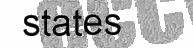

In [36]:
idx = 5
print(adv_txt_list[idx],target_txt[idx])
show(adv_img[idx]) # optimized img

# post-process

## saliency map

In [ ]:
adv_img[]

In [66]:
(imga - imgb).min()

-0.7419102145176307

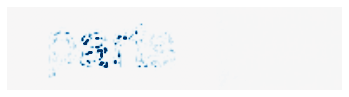

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
idx = 66
imga = adv_img[idx]
imgb = input_img[idx]
# imgb = wm0_img[idx]

# x = (imga - imgb).T
# x = (imga - imgb).T * ((imga - imgb) > 0).T
x = (imga - imgb).T * ((imga - imgb) < 0).T

plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.imshow(
    x,
    cmap='RdBu_r',
    interpolation='bilinear',
    vmin=-0.2,
    vmax=0.2,
)

## generate full image

In [ ]:
nb_line = 16
full_adv_img = np.zeros((48*nb_line, adv_img[0].shape[0]))
for i in range(nb_line):
    full_adv_img[i*48:(i+1)*48] = 1 - adv_img[i+61].T
cvt2Image(full_adv_img).save('opt-real-images/full-4.jpg', quality=100)

In [ ]:
for idx in range(10):
    show(adv_img[idx]).save(f'opt-real-images/{target_txt[idx]}.jpg', quality=100)

# weaken & strengthen

## weaken data
basic mim attack: replace-full-word

In [ ]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/Arial-replace-full-word.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
with open(f'attack_result/Arial-replace-full-word-l2-eps0.2-ieps5.0-iter2000.pkl', 'rb') as f:
    adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)

In [ ]:
input_img = adv_img
target_txt = gt_txt

nb_sample = 100
len_x, target_txt = len_x[:nb_sample], target_txt[:nb_sample]
input_img = input_img[:nb_sample]

In [ ]:
idx = 6
print(record_adv_text[idx])
show(adv_img[idx])

basic opt attack: replace-full-word

In [ ]:
font_name = 'Arial'
case = 'replace-full-word'
with open(f'basic_opt_result/{font_name}-{case}.pkl', 'rb') as f:
    (input_img, adv_txt_list, adv_l2, adv_iter_list, adv_asr_list, duration) = pickle.load(f)

In [ ]:
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    _, _, len_x, gt_txt, target_txt = pickle.load(f)

In [ ]:
input_img, len_x, target_txt = input_img[:batch_size], len_x[:batch_size], gt_txt[:batch_size]

## strengthen attack

### gradient attack

In [ ]:
# build graph
with graph.as_default():
    inputs, input_seq_len, targets, dropout_rate, _, _ = network.create_placeholders()
    output_seq_len, time_major_logits, time_major_softmax, logits, softmax, decoded, sparse_decoded, scale_factor, log_prob = \
                        network.create_network(inputs, input_seq_len, dropout_rate, reuse_variables=tf.AUTO_REUSE)
    loss = tf.nn.ctc_loss(labels=targets,
                          inputs=time_major_logits,
                          sequence_length=output_seq_len,
                          time_major=True,
                          ctc_merge_repeated=True,
                          ignore_longer_outputs_than_inputs=True)
    loss = -tf.reduce_mean(loss, name='loss')
    grad, = tf.gradients(loss, inputs)

    # Normalize current gradient and add it to the accumulated gradient
    red_ind = list(range(1, len(grad.get_shape())))
    avoid_zero_div = tf.cast(1e-12, grad.dtype)
    divisor = tf.reduce_mean(tf.abs(grad), red_ind, keepdims=True)
    norm_grad = grad / tf.maximum(avoid_zero_div, divisor)

    m = tf.placeholder(tf.float32,
                       shape=inputs.get_shape().as_list(),
                       name="momentum")
    acc_m = m + norm_grad

    grad = acc_m
    # ord=np.inf
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation_inf = utils_tf.mul(0.01, optimal_perturbation)
    # ord=2
    square = tf.maximum(1e-12, tf.reduce_sum(tf.square(grad), axis=red_ind, keepdims=True))
    optimal_perturbation = grad / tf.sqrt(square)
    scaled_perturbation_2 = utils_tf.mul(0.01, optimal_perturbation)

In [ ]:
# run attack
batch_size = 100
clip_min, clip_max = 0.0, 1.0
target_index_list = [np.asarray([c for c in encode(t)]) for t in target_txt]
with graph.as_default():
    adv_img = input_img.copy()
    m0 = np.zeros(input_img.shape)
    record_iter = np.zeros(input_img.shape[0])  # 0代表没成功

    start = time.time()
    for i in tqdm(range(nb_iter)):
        # perform attack
        batch_iter = len(input_img) // batch_size
        batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
        for batch_i in range(batch_iter):
            batch_input_img = input_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_m0 = m0[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_txt = target_txt[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_tmp_y = [np.asarray([c - 1 for c in encode(t)]) for t in batch_target_txt]
            batch_y = sparse_tuple_from(batch_tmp_y)
            batch_record_iter = record_iter[batch_size * batch_i:batch_size * (batch_i + 1)]

            scaled_perturbation = scaled_perturbation_2 if pert_type == '2' else scaled_perturbation_inf
            batch_pert, batch_loss = sess.run([scaled_perturbation, loss], # pert type
                                  feed_dict={
                                      inputs: batch_adv_img,
                                      input_seq_len: batch_len_x,
                                      m: batch_m0,
                                      targets: batch_y,
                                      dropout_rate: 0,
                                  })
            batch_pert[batch_record_iter != 0] = 0
            batch_adv_img = batch_adv_img + eps_iter * batch_pert
            batch_adv_img = batch_input_img + np.clip(batch_adv_img - batch_input_img, -eps, eps)
            batch_adv_img = np.clip(batch_adv_img, clip_min, clip_max)
            adv_img[batch_size * batch_i:batch_size * (batch_i + 1)] = batch_adv_img

        # check whether attack success
        record_adv_text = []
        for batch_i in range(batch_iter):
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_index = target_index_list[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_text = sess.run(decoded,
                                      feed_dict={
                                          inputs: batch_adv_img,
                                          input_seq_len: batch_len_x,
                                          dropout_rate: 0,
                                      })
            batch_adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_adv_text)
            record_adv_text += [''.join(decode(index)) for index in batch_adv_index]
            for j in range(len(batch_target_index)):
                # attack img idx_j successfully at iter i
                idx_j = batch_size * batch_i + j
                adv_index, target_index = batch_adv_index[j], batch_target_index[j]
                if np.sum(adv_index != target_index) == 0 and record_iter[idx_j] == 0:
                    record_iter[idx_j] = i
        # check whether all examples are successful
        if np.sum(record_iter == 0) == 0:
            print(f"{i} break.")
            break